## Histopathologic Cancer Detection
The purpose of this jupyter notebook is to create a learning algorithm to identify **metastatic cancer** in small image patches taken from larger digital pathology scans. 

You can find out more about this problem/competition [Here](https://www.kaggle.com/c/histopathologic-cancer-detection)

### Plan of action
We will first load all libraries to both explore and work with the data. 

We will then take a deeper dive into the data, to get an understanding of how labeling takes place

After we will be utilizing **Fast AI's** Deep Learning Framework (Built on top of Pytorch) to first create a *data object*, come up with data augmentation methods, and finally experiment with a *pretrained, resnet34* model 

Later, we will experiment with a larger ResNet model and other fine-tuned regularization techniques 

Eventually we will use Test Time Augmentation 

Finally we will use this to submit our predictions

In [0]:
!pip install kaggle --upgrade
!pip install fastai

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.2)
  Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built wrapt
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: wrapt 1.11.1
    Uninstalling wrapt-1.11.1:
      Successfully uninstalled wrapt-1.11.1


In [0]:
import pandas as pd
import numpy as np

from fastai import *
from fastai.vision import *

import os
import torch
from torchvision.models import *

In [18]:
# checking if enabled
torch.backends.cudnn.enabled == True

True

In [0]:
# configuring kaggle
!mkdir .kaggle # we will store in this directory

cred = json.dumps({"username":"USERNAME","key":"KEY"}) # change with your credentials
with open('.kaggle/kaggle.json', 'w') as f:
  f.write(cred) # writes to the .kaggle folder
  
# Configuring the file - we will run this twice (second time next block)
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [0]:
# run for second time
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
# making private
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Creating directories and paths
!mkdir data
!mkdir data/images # will contain all raw images

path = '/content/data'
images_path = '/content/data/images'

In [0]:
os.listdir(path)
os.listdir(images_path)

[]

In [0]:
# Downloading our images
!kaggle competitions download -c histopathologic-cancer-detection -f train.zip -p {path}
!kaggle competitions download -c histopathologic-cancer-detection -f train_labels.csv -p {path}

100% 4.98G/4.98G [02:14<00:00, 48.7MB/s]
100% 4.98G/4.98G [02:14<00:00, 39.7MB/s]
 98% 5.00M/5.10M [00:00<00:00, 5.80MB/s]
100% 5.10M/5.10M [00:00<00:00, 5.85MB/s]


In [0]:
# Unzipping files
!unzip -q -n {path}/train.zip -d {images_path} 
!unzip -q -n {path}/train_labels.csv.zip -d {path}

In [0]:
# Removing zip file
!rm -rf {path}/train.zip
!rm -rf {path}/train_labels.csv.zip

### Data Exploration

In [0]:
# Let's create paths
path = '/content/data'
images_path = '/content/data/images'
labels_path = '/content/data/train_labels.csv'

In [20]:
!ls data

images	models	train_labels.csv


In [21]:
# getting df
df = pd.read_csv(labels_path)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [22]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

### Creating Dataset

In [0]:
# Function to get our data
def get_data(image_size, batch_size, tfms):
  np.random.seed(42)
  data = ImageDataBunch.from_csv(path,csv_labels='train_labels.csv',folder='images', ds_tfms=tfms, size=image_size, suffix='.tif',bs=batch_size);
  stats=data.batch_stats()        
  data.normalize(stats)
  
  return data

### Building our model

In [0]:
arch_densenet = densenet169

In [0]:
# Setting transforms
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [0]:
batch_size = 64
image_size = 96

In [0]:
data = get_data(image_size, batch_size, tfms)

In [32]:
# Creating learner
learn = create_cnn(data, arch_densenet, metrics=[error_rate, accuracy])

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [15]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.219493,0.193069,0.073764,0.926236
2,0.145573,0.139315,0.049494,0.950506
3,0.140406,0.109503,0.038723,0.961277
4,0.113734,0.098981,0.034542,0.965458
5,0.108254,0.095624,0.034087,0.965913


In [0]:
learn.save('1-densenet169')

### Fine-tuning LR

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


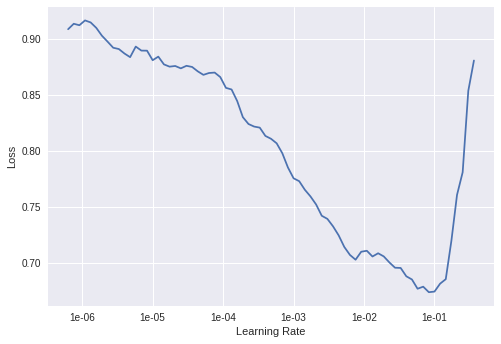

In [29]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 6e-3

In [34]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.218435,0.223529,0.086899,0.913101
2,0.193868,0.142810,0.052994,0.947006
3,0.160653,0.128793,0.047586,0.952415
4,0.125646,0.120314,0.037700,0.962300
5,0.105665,0.105398,0.033905,0.966095
